# Projet P6 : Classifiez automatiquement des biens de consommation

## Contexte

<b> MISSION 1 : </b>

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 
- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters
 
Pourrais-tu nous démontrer ainsi la faisabilité de regrouper automatiquement des produits de même catégorie ? 

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.
 
Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type bag-of-words, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

<b> MISSION 2 : </b>

Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle.

De plus, nous souhaitons élargir notre gamme de produits à l’épicerie fine. 
Pour cela, pourrais-tu tester la collecte de produits à base de “champagne” via l’API disponible  ici ?
https://developer.edamam.com/food-database-api

Pourrais-tu ensuite nous proposer un script ou notebook Python permettant une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

## Etapes du projet :

Démontrer la faisabilité de regrouper automatiquement des produits de même catégorie.

- <b> Etape préliminaire : </b> Importation des données ( --> NoteBook1 : Traitement des textes )
- <b> Etape 1 : </b> Text cleaning et feature engineering ( --> NoteBook1 : Traitement des textes ) 
- <b> Etape 2 : </b> Catégorisation des descriptions ( --> NoteBook 2 et 3 : Méthodes bag of words et Word_embedding )
- <b> Etape 3 : </b> Pré-traitement et classification d'images (SIFT et CNN) ( --> NoteBook4 : Traitement des images )
- <b> Etape 4 : </b> Classification supervisée des images ( --> NoteBook5 : Classification des images )
- <b> Etape 5 : </b> Collecte de produits via API ( --> NoteBook6 : Collecte produits API )


## Etape préliminaire : Importation des données et description des fichiers

ETAPE 0
- collecter et préparer les données dans un dataframe
- mettre en place un environnement de travail configuré avec les bibliothèques de traitement de données et de machine learning

### Environnement de travail et librairies

In [1]:
import sys
# Mon environnement virtuel :
print(sys.executable)
# La version de Python dans mon environnement virtuel :
print(sys.version)

C:\Users\druar\anaconda3\envs\Formation_P6\python.exe
3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC v.1938 64 bit (AMD64)]


In [ ]:
# Builtin
import os
# Définir le nombre de cœurs que vous souhaitez utiliser
os.environ['LOKY_MAX_CPU_COUNT'] = '14'
# Importer les autres bibliothèques après avoir défini la variable d'environnement
# import joblib

# Data
import numpy as np
import pandas as pd
# import scipy.stats as st
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# NLP - nltk
import nltk
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
# from nltk.corpus import words
from nltk.corpus import stopwords
# from nltk.tokenize import RegexpTokenizer
from nltk import ngrams

# Download éventuels à faire
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

# NLP - Spacy
import spacy
from spacy import displacy
spacy.cli.download("en_core_web_trf") # modèles du plus simple au plus complexe : en_core_web_sm, en_core_web_md, en_core_web_lg, en_core_web_trf
nlp = spacy.load("en_core_web_trf") 
# L'argument disable dans la fonction spacy.load est utilisé pour désactiver certaines composantes 
# du pipeline de traitement linguistique de spaCy lors du chargement d'un modèle.

# Test language modèle différent :
# from spacy.lang.en import English
# from spacy.pipeline.lemmatizer import Lemmatizer
# from spacy.lookups import load_lookups
# nlp = English()

# Reduction de dimensions
from sklearn import decomposition
from sklearn import manifold

# Viz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
# from PIL import Image
sns.set_palette('Set3')

# Clustering
from sklearn import cluster, metrics

# Augmenter les CPU
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True,
#                        nb_workers=6,
#                        #verbose=1
#                       )

### Importation et exploration des données

In [ ]:
articles_text = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\Flipkart\\flipkart_com-ecommerce_sample_1050.csv")

articles_text.head()

In [ ]:
# articles_text.tail()

In [7]:
# articles_text.sample(20)

In [8]:
articles_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [9]:
# Nb de valeurs uniques pour chaque colonne
articles_text.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [10]:
# product_category_tree = catégorie du produit
# description = description du produit

In [18]:
articles_text.isna().mean().sort_values()
# Aucunes valeurs manquantes sur les variables qui vont nous intéresser

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
retail_price               0.000952
discounted_price           0.000952
product_specifications     0.000952
brand                      0.321905
dtype: float64

In [20]:
# Valeurs dupliquées, individus identiques sur toutes les colonnes
# articles_text.duplicated().sum() = 0 
# Valeurs dupliquées dans chaque colonne :
for col in articles_text.columns :
    n = articles_text.duplicated(subset=col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : uniq_id -> duplicated : 0
col : crawl_timestamp -> duplicated : 901
col : product_url -> duplicated : 0
col : product_name -> duplicated : 0
col : product_category_tree -> duplicated : 408
col : pid -> duplicated : 0
col : retail_price -> duplicated : 695
col : discounted_price -> duplicated : 625
col : image -> duplicated : 0
col : is_FK_Advantage_product -> duplicated : 1048
col : description -> duplicated : 0
col : product_rating -> duplicated : 1023
col : overall_rating -> duplicated : 1023
col : brand -> duplicated : 559
col : product_specifications -> duplicated : 65


<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- nous avons 1050 descriptions de produits uniques dans l'échantillon de données
- il n'y a pas de valeurs manquantes dans les variables que nous allons exploiter
- il y a 642 catégories de produits différentes
- il y a 490 marques de produits différentes
    
</div>

## Etape 1 : Text cleaning et feature engineering

ETAPE 1
    
    1. Explorer le corpus de textes (tokenisation et analyse des fréquences)
       - Exploratory Data Analysis (EDA) : comprendre, explorer et effectuer un premier nettoyage des données

    2. Text processing : nettoyer et normaliser les données
       - Première passe de nettoyage : supprimer les stopwords
       - Deuxième passe : lemmatisation ou racinisation (stemming)

### 1. Explorer le corpus de textes - EDA

#### -- Selectionner les variables --

In [27]:
# Selection des variables qui vont nous intéresser
vars = ['product_category_tree','description']
articles_text = articles_text[vars]
articles_text.head()

,product_category_tree,description
0,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...


In [29]:
articles_text['product_category_tree'].value_counts(normalize=True)

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         0.053333
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           0.024762
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  0.021905
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         0.020952
["Home Furnishing >> Bath Linen >> Towels"]                                           0.018095
                                                                                        ...   
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]       0.000952
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]    0.000952
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]       0.000952
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]          0.000952
["Watches >> Wrist Watches >

#### -- Splitter la variable 'product_category_tree' en sous-catégories --

In [32]:
# Retier les signes [""] dans le texte de la variable
articles_text['product_category_tree'] = articles_text['product_category_tree'].str.slice(2, -2)
# Séparer les catégories en plusieurs colonnes
categories_split = articles_text['product_category_tree'].str.split(' >> ', expand=True)

# Renommer les colonnes pour une meilleure clarté
categories_split.columns = ['category_1', 'category_2', 'category_3','category_4', 'category_5', 'category_6','category_7']

# Joindre les nouvelles colonnes avec le DataFrame original
articles_text = articles_text.join(categories_split)
articles_text.head()

,product_category_tree,description,category_1,category_2,category_3,category_4,category_5,category_6,category_7
0,Home Furnishing >> Curtains & Accessories >> C...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
1,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
2,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None
3,Home Furnishing >> Bed Linen >> Bedsheets >> S...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None
4,Home Furnishing >> Bed Linen >> Bedsheets >> J...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None


In [34]:
articles_text.nunique()

product_category_tree     642
description              1050
category_1                  7
category_2                 62
category_3                241
category_4                349
category_5                297
category_6                117
category_7                 57
dtype: int64

In [36]:
articles_text['category_1'].value_counts()
# Le sample des produits a été réalisé en prenant 150 produits de chacune des 7 catégories ci-dessous

category_1
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [38]:
tmp = articles_text['category_2'].value_counts()
tmp.head(20)

category_2
Wrist Watches                149
Laptop Accessories            87
Infant Wear                   84
Coffee Mugs                   74
Showpieces                    71
Bed Linen                     65
Fragrances                    65
Network Components            49
Cookware                      27
Table Decor & Handicrafts     27
Combos and Kits               24
Wall Decor & Clocks           22
Bath Linen                    21
Curtains & Accessories        19
Makeup                        18
Baby Bedding                  15
Body and Skin Care            15
Baby & Kids Gifts             15
Baby Bath & Skin              14
Kitchen Tools                 14
Name: count, dtype: int64

#### -- Visualiser les descriptions des produits --

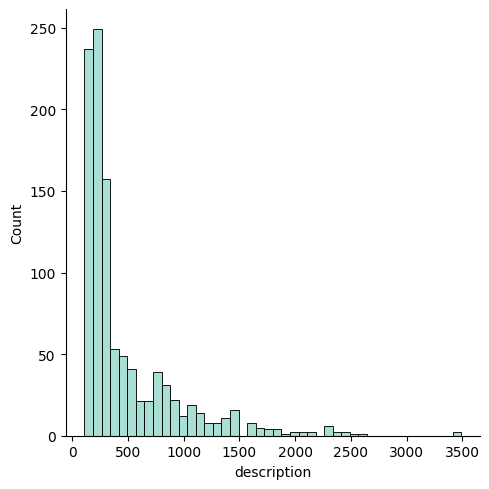

In [41]:
# Nombre de caractères
tmp = articles_text.description.str.len()
# sns.boxplot(tmp)
sns.displot(tmp)

In [43]:
# Stocker la longeur de la variable description
# articles_text["_len_description"] = tmp
# articles_text.head()

In [45]:
# Lire quelques descriptions au hasard :
articles_text_sample = articles_text.sample(20)

In [47]:
for idx, art in articles_text_sample.iterrows():
    txt_1 = f"Catégorie : {art['category_1']}\n"
    print(txt_1 + art['description'] + "..." + "\n\n")

Catégorie : Computers
Buy Netgear AC 750 Wi-Fi Range Extender only for Rs. 5999 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...


Catégorie : Home Furnishing
Buy Home Originals Polka, Abstract Double Blanket Multicolor at Rs. 1299 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


Catégorie : Beauty and Personal Care
Flipkart.com: Buy Cinthol Deo Spray - Intense (Pack of 2) Combo Set online only for Rs. 275 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...


Catégorie : Watches
Hourglass HG 006 Analog Watch  - For Men - Buy Hourglass HG 006 Analog Watch  - For Men  HG 006 Online at Rs.850 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


Catégorie : Computers
Buy Edimax BR-6288ACL only for Rs. 2840 from Flipkart.com. Only Genuine Products. 30 Day Replace

In [55]:
# Enregistrer les données intitiales filtrées pour le traitement avec BERT

# Créer le DataFrame
articles_text_BERT = pd.DataFrame({
    'description': articles_text['description'],
    'category_product': articles_text['category_1']
})
articles_text_BERT.to_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\articles_text_BERT.csv",index=False)

### 2. Text processing : nettoyer et normaliser les données

In [50]:
# articles_clean_sample = articles_clean.sample(frac=0.3) 
# Pour prendre qu'une partie des données si la base est trop lourde pour les traitements

1. Tokenisation
2. Stopwords
3. Lemmatisation
4. Tokens uniques - tokens trop présents

#### -- Tokens dans les descriptions initiales --

In [275]:
list_tokens_initial = []
for sentence in articles_text['description'] : 
    tokenize_sentence = nltk.tokenize.word_tokenize(sentence)
    list_tokens_initial.append(tokenize_sentence)

In [277]:
# Nombre de mots (=tokens) dans les définitions initiales : 91 612
tokens_global = [item for sublist in list_tokens_initial for item in sublist]
len(tokens_global)

91612

In [279]:
len(set(tokens_global)) # mots uniques, set supprime les doublons

8167

On initialise : 
- les stopwords, ce sont les mots qui apparaissent très fréquemment mais qui n'apporte pas de sens à la phrase (comme "de", "le", "une")
- les mots (words) qui proviennent d'un dictionnaire anglais
- un lemmatizer, cette objet nous permet de préserver la racine des mots de tel sorte que deux mots ayant une même souche seront considérés comme un seul et même mot (exemple : 'voisine' et 'voisinage' seront tous deux changer en 'voisin')

In [282]:
stopwords = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())
lemma = WordNetLemmatizer()
# lemmatizer = nlp.get_pipe("lemmatizer")

In [284]:
def Preprocess_listofSentence(listofSentence):
    ''' Fonction de preprocessing qui va successivement :
            - enlever la ponctuation et les majuscules
            - enlever les chiffres
            - transformer les phrases en liste de tokens (en liste de mots) et lemmatizer 
            - enlever les stopwords (mots n'apportant pas de sens)
            - retirer les mots de moins de 2 lettres
            - reformer les phrases avec les mots restants 
            - transformer les phrases finales en liste de tokens (en liste de mots)'''
    
    preprocess_description = []
    preprocess_tokens = []
    
    for sentence in listofSentence :
        
        # enlever la ponctuation et les majuscules
        sentence_w_punct = "".join([i.lower() for i in sentence if i not in string.punctuation])
        
        # enlever les chiffres
        sentence_w_num = ''.join(i for i in sentence_w_punct if not i.isdigit())
        
        # Spacy lemmatizer et transformer les phrases en tokens
        # tokens = nlp(sentence_w_num)
        # words_lemmatize = [w.lemma_ for w in tokens]
        
        # Nltk transformer les phrases en tokens et lemmatizer
        tokens = word_tokenize(sentence_w_num)
        words_lemmatize = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w,pos='v'),pos='n'),pos='a') for w in tokens]
        
        # enlever les stopwords (mots n'apportant pas de sens)
        words_w_stopwords = [i for i in words_lemmatize if i not in stopwords]
        
        # Enlever les mots de deux lettres ou moins
        words_filtered = [w for w in words_w_stopwords if len(w) > 2]
        
        # reformer les phrases avec les mots restants
        sentence_clean = ' '.join(w for w in words_filtered)
        
        # transformer les phrases finales en liste de tokens (en liste de mots)
        tokenize_description = word_tokenize(sentence_clean)
        
        preprocess_tokens.append(tokenize_description)
        preprocess_description.append(sentence_clean)
    
    return preprocess_description, preprocess_tokens

In [286]:
# Avec nltk :
tokens = word_tokenize('features dogs executed lovely exclusively assorted absorbency')
tmp = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w,pos='v'),pos='n'),pos='a') for w in tokens]

In [288]:
tmp[0:50]

['feature', 'dog', 'execute', 'lovely', 'exclusively', 'assort', 'absorbency']

In [290]:
# Avec spacy :
tokens = nlp('features dogs executed lovely exclusively assorted absorbency')
for token in tokens:
    print(f"Token: {token.text}, POS Tag: {token.pos_}, Lemmatise: {token.lemma_}")

Token: features, POS Tag: VERB, Lemmatise: feature
Token: dogs, POS Tag: NOUN, Lemmatise: dog
Token: executed, POS Tag: VERB, Lemmatise: execute
Token: lovely, POS Tag: ADJ, Lemmatise: lovely
Token: exclusively, POS Tag: ADV, Lemmatise: exclusively
Token: assorted, POS Tag: ADJ, Lemmatise: assorted
Token: absorbency, POS Tag: NOUN, Lemmatise: absorbency


In [292]:
# Phrase à analyser
text = articles_text['description'][50]
# Analyse de la phrase
doc = nlp(text)
# Affichage des tokens avec leurs POS tags
for token in doc:
    print(f"Token: {token.text}, POS Tag: {token.pos_}")

Token: Key, POS Tag: PROPN
Token: Features, POS Tag: NOUN
Token: of, POS Tag: ADP
Token: AKUP, POS Tag: ADJ
Token: life, POS Tag: NOUN
Token: -, POS Tag: PUNCT
Token: is, POS Tag: AUX
Token: -, POS Tag: PUNCT
Token: not, POS Tag: PART
Token: -, POS Tag: PUNCT
Token: living, POS Tag: VERB
Token: Ceramic, POS Tag: PROPN
Token: Mug, POS Tag: PROPN
Token: Pack, POS Tag: PROPN
Token: of, POS Tag: ADP
Token: 1, POS Tag: NUM
Token: Mug, POS Tag: PROPN
Token: ,, POS Tag: PUNCT
Token: AKUP, POS Tag: ADJ
Token: life, POS Tag: NOUN
Token: -, POS Tag: PUNCT
Token: is, POS Tag: AUX
Token: -, POS Tag: PUNCT
Token: not, POS Tag: PART
Token: -, POS Tag: PUNCT
Token: living, POS Tag: VERB
Token: Ceramic, POS Tag: PROPN
Token: Mug, POS Tag: PROPN
Token: (, POS Tag: PUNCT
Token: 300, POS Tag: NUM
Token: ml, POS Tag: NOUN
Token: ), POS Tag: PUNCT
Token: Price, POS Tag: NOUN
Token: :, POS Tag: PUNCT
Token: Rs, POS Tag: NOUN
Token: ., POS Tag: NOUN
Token: 259, POS Tag: NUM
Token: AKUP, POS Tag: ADJ
Token: C

In [294]:
# lemmatizer.lemmatize('brilliantly',pos='v') # Par défaut, appliqué sur les noms uniquement, pos='v' pour les verbes
# PorterStemmer, un peu strict dans notre cas, coupe tous les sufixes, préfixes
# Tester le lemmatizer de Spacy, différents niveaux de complexité, plus lent et paraît moins efficace sur nos données

In [296]:
preprocess_description, preprocess_tokens = Preprocess_listofSentence(articles_text['description'])

In [297]:
print('Phrase de base : '+articles_text['description'][50]+'\n')
print('Phrase nettoyée : '+preprocess_description[50]+'\n')
print('Tokens nettoyés : ')
print(preprocess_tokens[50])

Phrase de base : Key Features of AKUP life-is-not-living Ceramic Mug Pack of 1 Mug,AKUP life-is-not-living Ceramic Mug (300 ml) Price: Rs. 259 AKUP Ceramic coffee mugs gives you the best quality printed mugs which you can gift to your loved ones. We provide good quality of products with packing. Coffee mugs made of ceramic clay with the volume capacity of 300ml each. You can buy it for yourself to make your moment unforgettable forever. Specifications Product Dimensions: Mugs - Height: 9.5 cms, Diameter: 8 cms. Item Type: Coffee Mug Color: Multi-Color Material: Clay Finish: Glossy Specialty: Lovely Style Wash care: Remove dirt by using a soft fabric to clean and then wipe with a moist cloth. Disclaimer: The fine design, pattern and color tone of the product may vary slightly from that shown in the image. However, there would not be any compromise in quality. Brand: AKUP designs & co,Specifications of AKUP life-is-not-living Ceramic Mug (300 ml) General Type Mug Mug Capacity 300 ml Mate

#### -- Filtre sur les tokens --

In [431]:
# Analyse des tokens au global :
tokens_global = [item for sublist in preprocess_tokens for item in sublist]
print(tokens_global[:30])

['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtainelegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhance', 'look', 'interiorsthis', 'curtain', 'make', 'high', 'quality', 'polyester', 'fabricit']


In [433]:
len(tokens_global)
# Il y a 52231 tokens dans les descriptions après le 1er nettoyage

52231

In [435]:
len(set(tokens_global)) # 4640 mots uniques, set supprime les doublons

4640

In [437]:
tmp = pd.Series(tokens_global).value_counts()
tmp.head(30)
# On pourrait déjà supprimer une grande partie de ces termes ? > 250 ? le problème est que 'mug' apparaît assez vite et 'watch'
# tmp.tail(20)

product        861
free           612
buy            583
ship           569
delivery       567
cash           564
genuine        564
replacement    559
price          557
day            552
guarantee      473
flipkartcom    472
mug            449
feature        407
online         396
color          360
design         360
watch          355
pack           341
make           338
type           324
baby           320
material       307
set            306
box            294
general        288
cotton         286
package        277
print          276
sale           262
Name: count, dtype: int64

In [439]:
list_many_words = tmp[tmp>450]
list_many_words[:20]

product        861
free           612
buy            583
ship           569
delivery       567
cash           564
genuine        564
replacement    559
price          557
day            552
guarantee      473
flipkartcom    472
Name: count, dtype: int64

In [441]:
tmp.describe()
# On pourrait également supprimer les tokens présents une seule fois dans le corpus, il y en a plus de 25%

count    4640.000000
mean       11.256681
std        42.065730
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       861.000000
Name: count, dtype: float64

In [443]:
list_unique_words = tmp[tmp<=5]
list_unique_words[:30]

hdmi            5
shoppingtara    5
majesty         5
band            5
quickly         5
frenemy         5
pepper          5
across          5
rejuvenate      5
agromech        5
nursery         5
format          5
bean            5
infuse          5
suave           5
watche          5
cow             5
cargo           5
edimax          5
trendnet        5
wonderchef      5
soften          5
relative        5
cast            5
background      5
whats           5
tiedribbons     5
minimum         5
shrug           5
plan            5
Name: count, dtype: int64

In [445]:
len(list_unique_words)
# 1548 tokens sont présents 1 seule fois
# 1022 tokens sont présents 2 fois
## 2570 tokens sont présents 2 fois ou moins
# 423 tokens sont présents 3 fois
# 3465 tokens sont présents 5 fois ou moins

3465

In [447]:
list_unique_words = list(list_unique_words.index)
list_many_words = list(list_many_words.index)

In [449]:
# Sauvegarder cette liste dans un df :
tmp = pd.DataFrame({"words" : list_unique_words})
# tmp.to_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\words_2.csv",index=False)
tmp.to_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\words_5.csv",index=False)

In [451]:
# On fait la même manipulation pour conserver la liste des mots les plus courants : pour le moment, on conserve tout
tmp = pd.DataFrame({"words" : list_many_words})
tmp.to_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\words_many.csv",index=False)

In [453]:
# Chargement du fichier cleané
list_rare_words = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\words_5.csv")
list_rare_words = list(list_rare_words['words'])
list_many_words = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\words_many.csv")
list_many_words = list(list_many_words['words'])

In [455]:
def Preprocess_listofSentence2(listofSentence, 
                               list_rare_words, 
                               list_many_words
                              ):
    ''' Fonction de preprocessing2 qui va successivement :
            - transformer les phrases en liste de tokens (en liste de mots)
            - retirer les mots présents plusieurs fois dans le commentaire
            - reformer les phrases avec les mots restants 
            - transformer les phrases finales en liste de tokens (en liste de mots)'''
    
    preprocess_description = []
    preprocess_tokens = []
    
    for sentence in listofSentence :
        
        # transformer les phrases en liste de tokens (en liste de mots)
        tokenize_sentence = word_tokenize(sentence)
        
        # Après analyse : enlever les unique words (mots apparaissant 2 fois ou moins dans l'ensemble des descriptions)
        non_rares_tokens = [i for i in tokenize_sentence if i not in list_rare_words]
        
        # Après analyse : enlever les many words (mots apparaissant dans plusieurs définitions)
        non_many_tokens = [i for i in non_rares_tokens if i not in list_many_words]
        
        # Reformer les phrases avec les mots restants
        sentence_clean = ' '.join(w for w in non_rares_tokens)
        
        preprocess_tokens.append(non_rares_tokens)
        preprocess_description.append(sentence_clean)
    
    return preprocess_description, preprocess_tokens

In [457]:
preprocess2_description, preprocess2_tokens = Preprocess_listofSentence2(preprocess_description, list_rare_words, list_many_words)

In [459]:
# preprocess2_tokens = liste de liste de tokens [['','',''],[],...,[]]
# preprocess2_description = liste de descriptions ['','','',...,'']

In [461]:
print('Phrase de base : '+articles_text['description'][10]+'\n')
print('Tokens nettoyée phase 1 : ''\n')
print(preprocess_tokens[10])
print('Tokens nettoyés phase 2 : ''\n')
print(preprocess2_tokens[10])

Phrase de base : Calibro SW-125 Analog-Digital Watch  - For Men, Boys
                         Price: Rs. 699
				
			CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly it leads other brands in style, finish and everything else that matters.
CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well execute

#### -- Nombre de tokens après le 2e nettoyage --

In [464]:
# Analyse des tokens après le 2e nettoyage :
tokens_global = [item for sublist in preprocess2_tokens for item in sublist]
print(tokens_global[:30])

['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhance', 'look', 'curtain', 'make', 'high', 'quality', 'polyester', 'feature', 'eyelet', 'style']


In [466]:
len(tokens_global)
# Il y a 52231 tokens dans les descriptions après le 1er nettoyage
# Il y a 48639 tokens dans les descriptions après le 2 nettoyage (suppressions des mots qui apparaissent 2 fois ou moins)
# Il y a 45305 tokens dans les descriptions après le 2 nettoyage (suppressions des mots qui apparaissent 5 fois ou moins)

45305

In [468]:
len(set(tokens_global)) # mots uniques, set supprime les doublons
# Il y a 4640 tokens uniques dans les descriptions après le 1er nettoyage
# Il y a 2070 tokens uniques dans les descriptions après le 2 nettoyage (suppressions des mots qui apparaissent 2 fois ou moins)
# Il y a 1175 tokens uniques dans les descriptions après le 2 nettoyage (suppressions des mots qui apparaissent 5 fois ou moins)

1175

In [573]:
# Sauvegarder le df cleané
# Créer le DataFrame
articles_text_clean = pd.DataFrame({
    'tokens': preprocess2_tokens,
    'description': preprocess2_description,
    'category_product': articles_text['category_1'],
})
articles_text_clean.to_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\articles_text_clean.csv",index=False)

In [575]:
articles_text_clean.head()

,tokens,description,category_product
0,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...,Home Furnishing
1,"[specification, cotton, bath, towel, bath, tow...",specification cotton bath towel bath towel red...,Baby Care
2,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...,Baby Care
3,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...,Home Furnishing
4,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...,Home Furnishing


#### -- Représentation des mots --

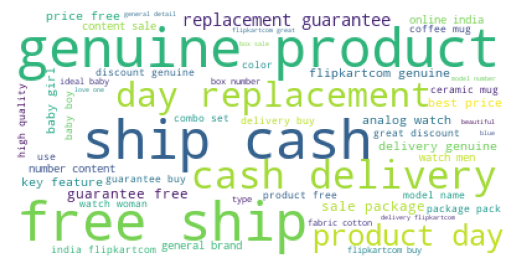

In [475]:
wordcloud = WordCloud (background_color = "white",
                      stopwords = set(),
                      max_words = 50).generate(" ".join(preprocess2_description)) ## par défaut, des bigrammes
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [571]:
# Validation : Afficher la longueur des tokens
df = articles_text_clean.copy()
df['token_count'] = df['tokens'].apply(len)

# Trouver le nombre maximum de tokens
max_tokens = df['token_count'].max()
print(f"Le nombre maximum de tokens dans la colonne 'tokens' est : {max_tokens}")

Le nombre maximum de tokens dans la colonne 'tokens' est : 285


<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- la phase de text processing a permi de passer d'un corpus global de 91612 tokens à un corpus de 45305 tokens
- parmis eux, on passe de 8167 tokens uniques avant nettoyage à 1175 tokens uniques
- cela facilitera le traitement des algorythmes en injectant des tokens pertinants en tant que features à analyser
    
</div>